In [1]:
import pandas as pd
import numpy as np
import fxcmpy
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use("seaborn")

/var/folders/vt/l70v337s047_p4k5c0kp45200000gn/T/ipykernel_34567/1223282370.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# Momentum Back Tester Class

In [2]:
class MomentumBacktester():
    ''' Class for the vectorized backtesting of simple Momentum trading strategies.
    '''    
    
    def __init__(self, symbol, start, end, tc, api = None, frequency = 'D1'):
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol (instrument) to be backtested
        start: str
            start date for data import
        end: str
            end date for data import
        tc: float
            proportional transaction/trading costs per trade
        api: fxcmpy.fxcmpy object
            if None, data is imported from Yahoo Finance, else data is imported from FXCM trading platform
        frequency: str
            time frame of the data
        '''
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.api = api
        self.frequency = frequency
        self.get_data()
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data from FXCM if api is provided else data is imported from yahoo-Finance.
        '''
        if self.api is None:
            raw = yf.download(self.symbol,self.start,self.end).Close.to_frame()
            raw = raw.rename(columns={'Close':'price'})
            raw["returns"] = np.log(raw / raw.shift(1))
            self.data = raw
        else:
            raw = self.api.get_candles(self.symbol, start = self.start, end = self.end, period = self.frequency)
            raw = raw['askclose'].to_frame()
            raw = raw.rename(columns={'askclose':'price'})
            raw["returns"] = np.log(raw / raw.shift(1))
            self.data = raw
        
    def test_strategy(self, window = 1):
        ''' Backtests the simple contrarian trading strategy.
        
        Parameters
        ----------
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
        data = self.data.copy().dropna()
        data["position"] = np.sign(data["returns"].rolling(self.window).mean())
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Window = {} | TC = {}".format(self.symbol, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_parameter(self, window_range):
        ''' Finds the optimal strategy (global maximum) given the window parameter range.

        Parameters
        ----------
        window_range: tuple
            tuples of the form (start, end, step size)
        '''
        
        windows = range(*window_range)
            
        results = []
        for window in windows:
            results.append(self.test_strategy(window)[0])
        
        best_perf = np.max(results) # best performance
        opt = windows[np.argmax(results)] # optimal parameter
        
        # run/set the optimal strategy
        self.test_strategy(opt)
        
        # create a df with many results
        many_results =  pd.DataFrame(data = {"window": windows, "performance": results})
        self.results_overview = many_results
        
        return opt, best_perf
                               

In [3]:
api = fxcmpy.fxcmpy(config_file= "FXCM.cfg")

In [16]:
tester = MomentumBacktester('EUR/USD', "2018-01-01", "2019-12-31", 0.00007,api,"D1")

In [17]:
tester.test_strategy(77)

(1.060412, 0.148193)

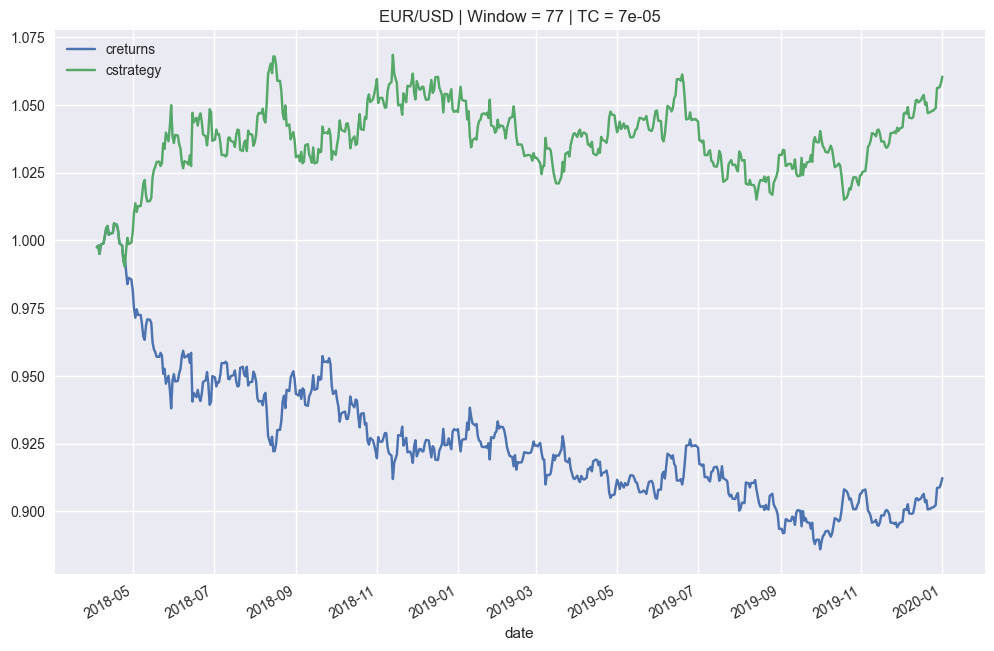

In [18]:
tester.plot_results()

In [15]:
tester.optimize_parameter((1, 100, 1))

(77, 1.06577)